# Topic Modelling of Customer Reviews with Latent Dirichlet Allocation Model: The case of UK Delivery Companies 

**Author: Georgios Spyrou (https://github.com/gpsyrou)**

_Last Update: 12/05/2021_

<img src="../img/twitter_sentiment_img.jpg" alt="Sentiment Picture" width="920" height="640">

### Sections
- <a href="#project_idea" style="text-decoration: none"> Project Description</a>

<a id='project_idea'></a>
### Introduction

In this project we are going to explore the world of logistic companies and the issues that they might be facing. Specifically, we are going to focus on analyzing data regarding a few of the most well-known delivery companies in the UK, namely <a href="https://en.wikipedia.org/wiki/Deliveroo" style="text-decoration:none"> Deliveroo</a>, <a href="https://en.wikipedia.org/wiki/UberEats" style="text-decoration:none"> UberEats</a>, <a href="https://en.wikipedia.org/wiki/Just_Eat" style="text-decoration:none"> Just Eat</a> and <a href="https://stuart.com/" style="text-decoration:none"> Stuart</a>. To do that we are going to utilize the internet and the reviews that we can find in many different platforms, especially these platforms that are specializing at collecting reviews and opininions of customers for a plethora of companies and services. 

The first iteration of this project it's using the reviews that can be found in the famous consumer review website <a href="https://en.wikipedia.org/wiki/Trustpilot" style="text-decoration:none"> TrustPilot</a>. Even though the website is already providing some API functionalities, we are going to write our own web-scraping tool to retrieve the data in the format that we want. We will attempt to collect as many reviews as possible and then use them to identify interesting findings in the text. For example, we will try to identify what is the sentiment across all reviews for a specific company, what are the most common words and bigrams (i.e. pairs of words that tend to appear next to each other) in the reviews, and more. Finally, we will implement a <a href="https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation" style="text-decoration:none"> Latent Dirichlet Allocation</a> model to try and identify what are the topics that these reviews correspond to.


We are going to discuss the specifics in more depth as we are going through the different parts of the project. As a starting point of course, we need to collect the relevant reviews for the aforementioned group of delivery companies.

### Web-Scrapping Tool and Data Retrieval

In [2]:
import os
import pandas as pd

project_dir = r'D:\GitHub\Projects\Analysis_of_Delivery_Companies_Reviews'
os.chdir(project_dir)

In [3]:
from helpers.utilities import splitRatingsColumn
from processing import text_processing as tp
from texteda import (most_common_words,
                     plot_most_common_words,
                     plot_wordcloud,
                     compute_bigrams,
                     plot_bigrams)

from nltk.corpus import stopwords

In [4]:
processed_pages_file = os.path.join(project_dir, 'processed_pages.txt')
reviews_base_file = os.path.join(project_dir, 'reviews.csv')

In [5]:
col_names = ['Company', 'Id', 'Reviewer_Id', 'Title', 'Review', 'Date', 'Rating']
ratings_dict = {1: 'Bad', 2: 'Poor', 3: 'Average', 4: 'Great', 5: 'Excellent'}      

base_df = pd.read_csv(reviews_base_file, sep=',')

In [6]:
base_df.head()

,Company,Id,Reviewer_Id,Title,Review,Date,Rating
0,Deliveroo,60709f95f85d75087052ff8b,60709f8f0a30fd001b06dc52,Ordered food and apparently the driver…,Ordered food and apparently the driver was wai...,2021-04-09 18:40,{2: 'Poor'}
1,Deliveroo,60708710f85d75087052c89b,6070870c2158190019b3ab8e,Disgusting Live Customer Service CHAT!!!,I received standard bag of buttons that cost £...,2021-04-09 16:55,{1: 'Bad'}
2,Deliveroo,60707b91f85d75087052abb6,602eb3ac49aeca0019ad4b70,Just had an appalling experience with…,Just had an appalling experience with delivero...,2021-04-09 16:06,{1: 'Bad'}
3,Deliveroo,60705919f85d7508705251d4,60705856348d93001ad1ca1f,The same situation happened twice,The same situation happened twice. I ordered f...,2021-04-09 13:39,{2: 'Poor'}
4,Deliveroo,60705138f85d750870523d4d,6070512519dc76001aebe4b1,Driver left without giving us food,Driver turned up late couldn’t find us and lef...,2021-04-09 13:06,{1: 'Bad'}


In [7]:
stopwords_ls = stopwords.words('english')
stopwords_ls.extend(['\'d', '\'m', '\'s', '\'ve', '\'re', '\'ll', 'n\'t', '’'])

common_delivery_words = ['delivery', 'deliver', 'driver', 'order', 'uber', 'stuart', 'deliveroo']
stopwords_ls.extend(common_delivery_words)

See a distribution of number of reviews among all companies

In [8]:

base_df['Company'].value_counts()

UberEats     7840
Deliveroo    5760
JustEat      1840
Stuart        160
Name: Company, dtype: int64

In [9]:
# Check for duplicates
base_df.drop_duplicates(inplace=True)

In [10]:
def splitRatingsColumn(rating_text):
    rating_text = rating_text.replace('\'','').replace('{','').replace('}','')
    return rating_text[0], rating_text[3:]

In [11]:
# Cast columns specific data format
base_df['Date'] = pd.to_datetime(base_df['Date'], format="%Y-%m-%d %H:%M", errors='coerce')
base_df['Rating'] = base_df['Rating'].apply(lambda row: splitRatingsColumn(row)[0]).astype(int)
base_df['Rating_Text'] = base_df['Rating'].apply(lambda row: ratings_dict[row])


In [12]:
# Transform dataset

# Delete rows where the review is empty
base_df = base_df[base_df['Review'].notna()]

# Split review in tokens and remove punctuation, stopwords
base_df['Review_Clean'] = base_df['Review'].apply(lambda row: tp.tokenize_and_clean(text=row, stopwords_ls=stopwords_ls))

# Lemmatize the tokens
base_df['Review_Lemma'] = base_df['Review_Clean'].apply(lambda row: tp.lemmatize(text=row, pos_type='n'))

# Join tokens into a single string
base_df['Review_Merged'] = base_df['Review_Lemma'].apply(lambda row: ' '.join([x for x in row]))

In [13]:
base_df.head(3)

,Company,Id,Reviewer_Id,Title,Review,Date,Rating,Rating_Text,Review_Clean,Review_Lemma,Review_Merged
0,Deliveroo,60709f95f85d75087052ff8b,60709f8f0a30fd001b06dc52,Ordered food and apparently the driver…,Ordered food and apparently the driver was wai...,2021-04-09 18:40:00,2,Poor,"[ordered, food, apparently, waiting, mins, foo...","[ordered, food, apparently, waiting, min, food...",ordered food apparently waiting min food even ...
1,Deliveroo,60708710f85d75087052c89b,6070870c2158190019b3ab8e,Disgusting Live Customer Service CHAT!!!,I received standard bag of buttons that cost £...,2021-04-09 16:55:00,1,Bad,"[received, standard, bag, buttons, cost, £1.60...","[received, standard, bag, button, cost, £1.60,...",received standard bag button cost £1.60 asked ...
2,Deliveroo,60707b91f85d75087052abb6,602eb3ac49aeca0019ad4b70,Just had an appalling experience with…,Just had an appalling experience with delivero...,2021-04-09 16:06:00,1,Bad,"[appalling, experience, ordered, pizza, £10, d...","[appalling, experience, ordered, pizza, £10, d...",appalling experience ordered pizza £10 discoun...


In [14]:
# Exploratory Data Analysis
most_common_words(base_df, text_col='Review_Merged', n_most_common=10)

,words,count
0,food,7266
1,service,7058
2,customer,5467
3,time,5126
4,refund,4828
5,never,4530
6,ordered,4077
7,get,3959
8,use,3742
9,restaurant,3452


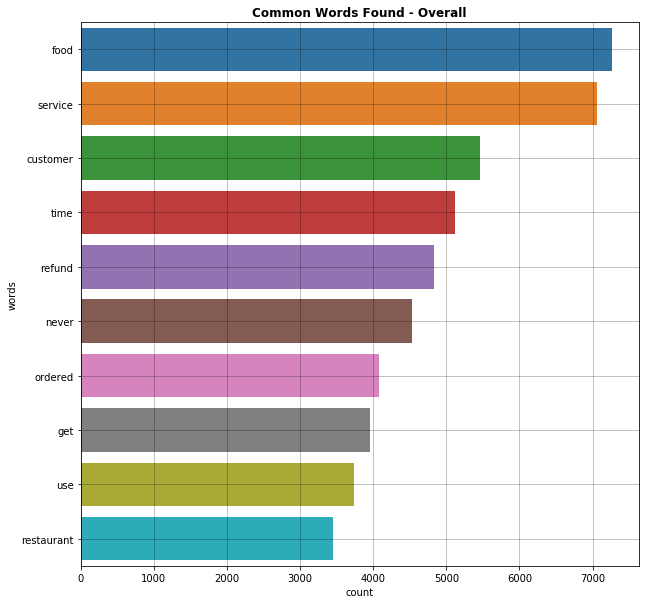

In [15]:
plot_most_common_words(base_df,  n_most_common=10, text_col='Review_Merged')


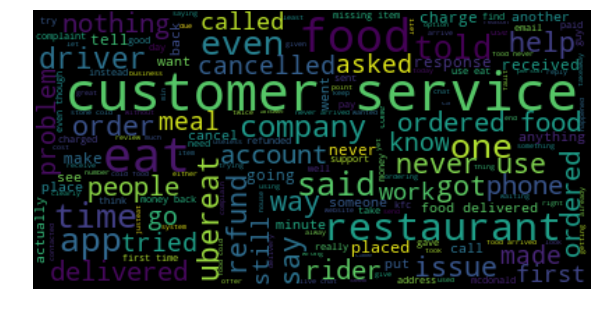

In [17]:
plot_wordcloud(base_df, text_col='Review_Merged')

In [21]:
bigrams = compute_bigrams(base_df, text_col='Review_Merged')

In [23]:
sorted(bigrams.items(), key=lambda item: item[1], reverse=True)

[(('customer', 'service'), 5080),
 (('never', 'use'), 1108),
 (('ordered', 'food'), 1009),
 (('food', 'delivered'), 682),
 (('missing', 'item'), 669),
 (('money', 'back'), 655),
 (('first', 'time'), 649),
 (('get', 'refund'), 592),
 (('even', 'though'), 556),
 (('never', 'arrived'), 519),
 (('food', 'never'), 450),
 (('food', 'arrived'), 424),
 (('live', 'chat'), 421),
 (('stone', 'cold'), 418),
 (('cold', 'food'), 402),
 (('said', 'would'), 387),
 (('use', 'eats'), 374),
 (('food', 'cold'), 366),
 (('service', 'ever'), 365),
 (('hour', 'later'), 363),
 (('refused', 'refund'), 362),
 (('customer', 'support'), 362),
 (('wrong', 'address'), 362),
 (('could', 'give'), 358),
 (('item', 'missing'), 358),
 (('use', 'service'), 350),
 (('last', 'time'), 348),
 (('full', 'refund'), 328),
 (('waste', 'time'), 326),
 (('get', 'food'), 321),
 (('promo', 'code'), 319),
 (('worst', 'customer'), 299),
 (('called', 'restaurant'), 296),
 (('never', 'received'), 294),
 (('terrible', 'customer'), 285),


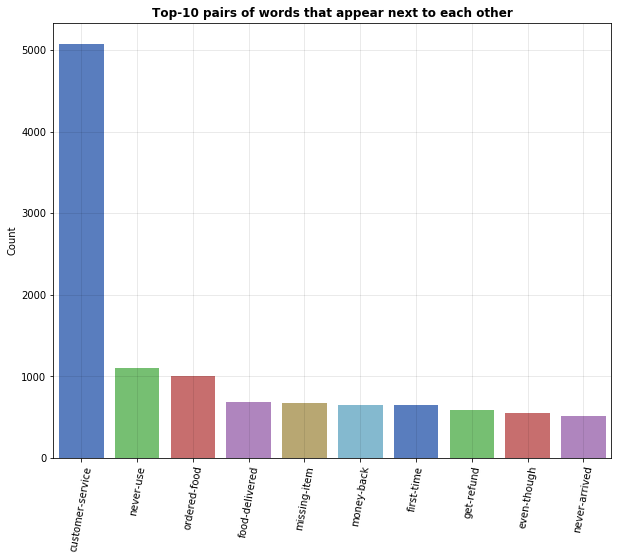

In [18]:
plot_bigrams(input_df=base_df, text_col='Review_Merged', top_n=10)

In [24]:
# Gensim
from pprint import pprint
import gensim
import gensim.corpora as corpora

# Create Dictionary
id2word = corpora.Dictionary(base_df['Review_Lemma'])

# Create Corpus
texts = base_df['Review_Lemma']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# number of topics
num_topics = 5

# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 5 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"service" + 0.014*"customer" + 0.013*"food" + 0.010*"restaurant" + '
  '0.010*"time" + 0.010*"refund" + 0.010*"get" + 0.009*"would" + '
  '0.009*"ordered" + 0.008*"told"'),
 (1,
  '0.025*"food" + 0.016*"time" + 0.013*"service" + 0.011*"customer" + '
  '0.010*"refund" + 0.009*"use" + 0.009*"would" + 0.009*"company" + '
  '0.008*"never" + 0.007*"ordered"'),
 (2,
  '0.016*"service" + 0.015*"customer" + 0.014*"food" + 0.011*"time" + '
  '0.009*"refund" + 0.009*"would" + 0.007*"app" + 0.007*"restaurant" + '
  '0.006*"get" + 0.006*"hour"'),
 (3,
  '0.021*"food" + 0.016*"time" + 0.014*"service" + 0.011*"customer" + '
  '0.011*"restaurant" + 0.010*"get" + 0.010*"never" + 0.009*"refund" + '
  '0.008*"eats" + 0.007*"even"'),
 (4,
  '0.024*"food" + 0.018*"service" + 0.013*"customer" + 0.011*"never" + '
  '0.010*"hour" + 0.010*"time" + 0.010*"refund" + 0.008*"would" + '
  '0.008*"ordered" + 0.008*"get"')]


In [25]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+ str(num_topics))

In [27]:
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

In [28]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.000107 -0.000188       1        1  35.873786
0      0.004169 -0.018192       2        1  19.981812
2      0.010974 -0.000820       3        1  15.992972
1     -0.022501  0.001828       4        1  15.389800
3      0.007252  0.017373       5        1  12.761630, topic_info=            Term          Freq         Total Category  logprob  loglift
term                                                                   
44          time   7267.000000   7267.000000  Default  30.0000  30.0000
6           food  11940.000000  11940.000000  Default  29.0000  29.0000
324   restaurant   4988.000000   4988.000000  Default  28.0000  28.0000
10       service  10362.000000  10362.000000  Default  27.0000  27.0000
2       customer   7714.000000   7714.000000  Default  26.0000  26.0000
164         call   2332.000000   2332.000000  Default  25.0000  25.0000
28           get   4865.000000   4865.000000  Default  24.0000  24.0000
1254        eats   3000.000000   3000.000000  Default  23.0000  23.0000
39        refund   5945.000000   5945.000000  Default  22.0000  22.0000
77           use   4012.000000   4012.000000  Default  21.0000  21.0000
310      company   3388.000000   3388.000000  Default  20.0000  20.0000
5           even   3316.000000   3316.000000  Default  19.0000  19.0000
68         never   5234.000000   5234.000000  Default  18.0000  18.0000
50         wrong   1898.000000   1898.000000  Default  17.0000  17.0000
329        using   2182.000000   2182.000000  Default  16.0000  16.0000
4            eat   2334.000000   2334.000000  Default  15.0000  15.0000
82         would   4880.000000   4880.000000  Default  14.0000  14.0000
206    delivered   3490.000000   3490.000000  Default  13.0000  13.0000
66         money   3307.000000   3307.000000  Default  12.0000  12.0000
316         good   1232.000000   1232.000000  Default  11.0000  11.0000
163         back   2591.000000   2591.000000  Default  10.0000  10.0000
181          app   3254.000000   3254.000000  Default   9.0000   9.0000
243        phone   1820.000000   1820.000000  Default   8.0000   8.0000
612       minute   2576.000000   2576.000000  Default   7.0000   7.0000
107         late   1259.000000   1259.000000  Default   6.0000   6.0000
116         give   2176.000000   2176.000000  Default   5.0000   5.0000
318         like   1773.000000   1773.000000  Default   4.0000   4.0000
34           one   2866.000000   2866.000000  Default   3.0000   3.0000
1164    terrible   1235.000000   1235.000000  Default   2.0000   2.0000
338      arrived   1878.000000   1878.000000  Default   1.0000   1.0000
...          ...           ...           ...      ...      ...      ...
603         keep    170.595732    735.393593   Topic5  -6.1088   0.5976
894        price    107.001018    399.536320   Topic5  -6.5752   0.7413
238       number    237.745945   1166.317529   Topic5  -5.7769   0.4683
561           wo    137.262797    566.947987   Topic5  -6.3262   0.6404
744        waste    128.255060    526.026548   Topic5  -6.3941   0.6474
329        using    371.632277   2182.173450   Topic5  -5.3302   0.2886
243        phone    316.154127   1820.381226   Topic5  -5.4919   0.3082
116         give    356.701297   2176.560374   Topic5  -5.3712   0.2501
10       service   1088.062157  10362.439060   Topic5  -4.2559  -0.1951
2       customer    868.060555   7714.103899   Topic5  -4.4818  -0.1258
39        refund    714.112937   5945.488915   Topic5  -4.6770  -0.0606
206    delivered    482.850918   3490.247633   Topic5  -5.0684   0.0807
137        every    149.683704    716.771120   Topic5  -6.2396   0.4925
375          let    134.665334    632.961910   Topic5  -6.3453   0.5111
318         like    283.537726   1773.861168   Topic5  -5.6007   0.2252
50         wrong    294.339028   1898.549615   Topic5  -5.5634   0.1946
77           use    490.754959   4012.638055   Topi

In [17]:
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared

PermissionError: [Errno 13] Permission denied: './results/ldavis_prepared_5'